In [1]:
Packages <- c("dplyr","pracma","cubature","data.table", "gridExtra","viridis", "ggsignif", "broom", "ggpubr", "caret","cowplot","ggplot2","fields","bbmle", "dplyr", "tidyr", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/kernel_fitting/')

load("~/parentage/r_data/site_dist_info.RData")

#final scripts to use
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_optim.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0

## Plot kernel results 

In [2]:
# read in kernel results for plotting
kernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", header=T)
kernels

Year,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispDist,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,NumParentageMatches,NumOffsSampled,PercentAssigned,MedianDispDist,Dist90Retained,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper
2012,-2.36,1.03,-7.22,-1.90,0.48,1.10,10.165094,0.000000,1.367946e+26,3,63,4.76,7.13,23.29,3.19,1.530115e+13
2013,4.04,0.22,3.59,4.06,0.20,0.24,69.586280,7.978681,1.233879e+05,21,150,14.00,12.20,157.36,2.57,2.061640e+03
2014,0.49,0.38,-0.26,0.81,0.37,0.40,15.037515,5.646667,2.204186e+05,13,181,7.18,5.53,38.13,3.02,2.984700e+03
2015,-1.52,0.67,-2.08,-1.13,0.56,0.70,10.180222,6.149556,2.404633e+02,11,111,9.91,5.82,24.91,2.31,1.118000e+01
2016,-3.04,5.00,-3.07,-2.88,2.16,5.00,10.100794,7.600055,1.311733e+01,6,111,5.41,9.63,18.91,5.85,4.458000e+01
2017,2.94,0.26,2.66,3.64,0.23,0.26,29.062101,5.920487,1.172967e+04,13,130,10.00,6.68,69.72,3.03,5.452225e+05
2018,-2.32,1.37,-2.93,-2.15,1.36,1.61,7.191634,4.507346,5.079209e+01,4,45,8.89,5.55,15.72,2.58,1.276000e+01
2012-18,-2.51,1.49,-2.51,-2.48,1.32,1.60,8.153016,7.132250,9.403629e+00,71,791,8.98,6.44,17.58,4.94,8.130000e+00


In [24]:
profile_all_df <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_AllYears.csv", header=T) 

profile_all_df95 <- profile_all_df %>% 
        #filter(log_like < cutoff_all) %>%
        sample_n(500)


k_all <- as.numeric(kernels %>%
                     filter(Year=="2012-18") %>%
                     select(best_k))
theta_all <- as.numeric(kernels %>%
                     filter(Year=="2012-18") %>%
                     select(best_theta))

MDD_all <- as.numeric(kernels %>%
                     filter(Year=="2012-18") %>%
                     select(MeanDispDist))


max_dist <- 60
possible_dist <- matrix(seq(0,max_dist,0.1))
to_plot <- matrix(nrow=nrow(profile_all_df95), ncol=nrow(possible_dist))

for(i in 1:nrow(profile_all_df95)) {
     
    k <- profile_all_df95$k_eval[i]
    theta <- profile_all_df95$theta_eval[i]
    
    for(j in 1:nrow(possible_dist)) {
    
    dist <- possible_dist[j]
    to_plot[i,j] <- predicted_disp(k=k, theta=theta, d=dist)
    
    }
}

to_plot_df <- as.data.frame(to_plot) 

col <- as.character(possible_dist)
colnames(to_plot_df) <- col
to_plot_df <- bind_cols(profile_all_df95, to_plot_df) %>%    
    group_by(k_eval, theta_eval) 

to_plot_df2 <- to_plot_df %>%
    gather(4:604, key=dist, value=pdf) %>%
    mutate(dist=as.numeric(dist))
dim(to_plot_df2)
to_plot_df2$iter <- paste0(to_plot_df2$k_eval, '_', to_plot_df2$theta_eval) # create an identifier for each sample from the LL surface

##make a df to project the kernel
kernel_all <- data.frame(dist=seq(0,max_dist,0.1))
k= k_all
theta=theta_all

kernel_all <- kernel_all %>%
    mutate(pdf= predicted_disp(k=k, theta=theta, d=dist))




[1] 300500      5

Warning message:
“Removed 40000 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”

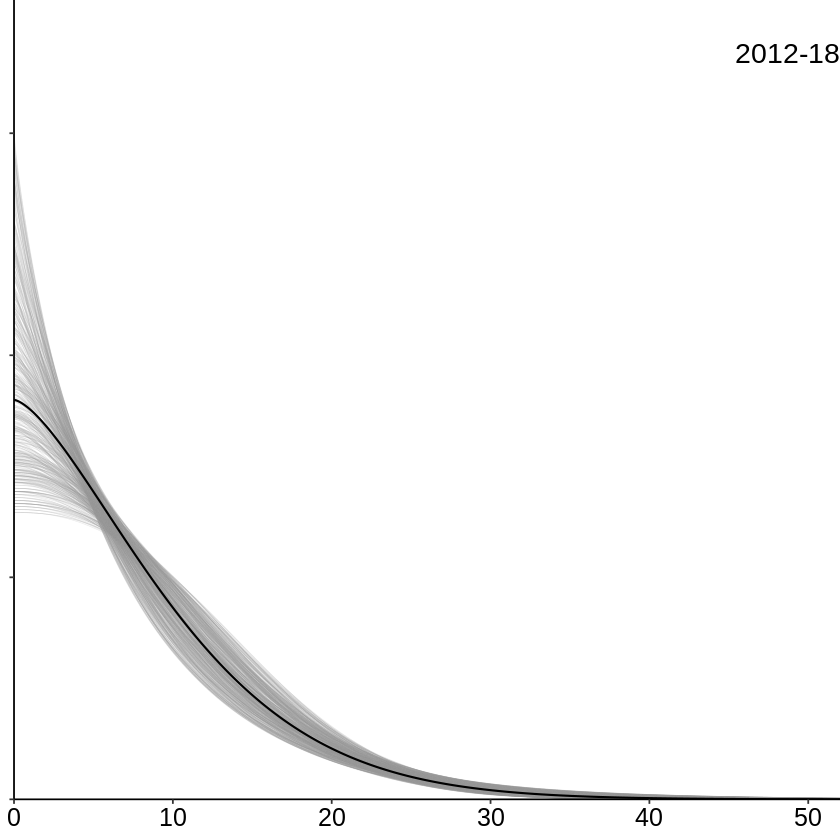

In [28]:
disp_all_pub <- ggplot(data=kernel_all, aes(x=dist, y=pdf))+ 
    geom_line(data=to_plot_df2, aes(x=dist, y=pdf, group=iter), color="gray60", size=.2, alpha=0.2)+
    #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2012-18", size=6, family="Helvetica")+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    #annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    #scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    #scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    geom_line(color="black", size=.6) +  
    #geom_vline(xintercept = MDD15, linetype="dotted", color = "deepskyblue2", size=1) +
    theme(axis.title.y=element_blank(),
    axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #ylab("Probability density") + 
    guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) 


disp_all_pub
#ggsave(filename="disp12_pub.pdf", plot=disp12_pub, path="~/parentage/kernel_fitting/1240_loci/final_results/kernel_plots" )


Warning message:
“Removed 40095 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”Warning message:
“Removed 41624 rows containing missing values (geom_path).”Warning message:
“Removed 83 rows containing missing values (geom_path).”Warning message:
“Removed 40928 rows containing missing values (geom_path).”Warning message:
“Removed 85 rows containing missing values (geom_path).”Warning message:
“Removed 40401 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”Warning message:
“Removed 40000 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”Warning message:
“Removed 42190 rows containing missing values (geom_path).”Warning message:
“Removed 85 rows containing missing values (geom_path).”Warning message:
“Removed 40438 rows containing missing values (geom_path).”Warning message:
“Removed 80 r

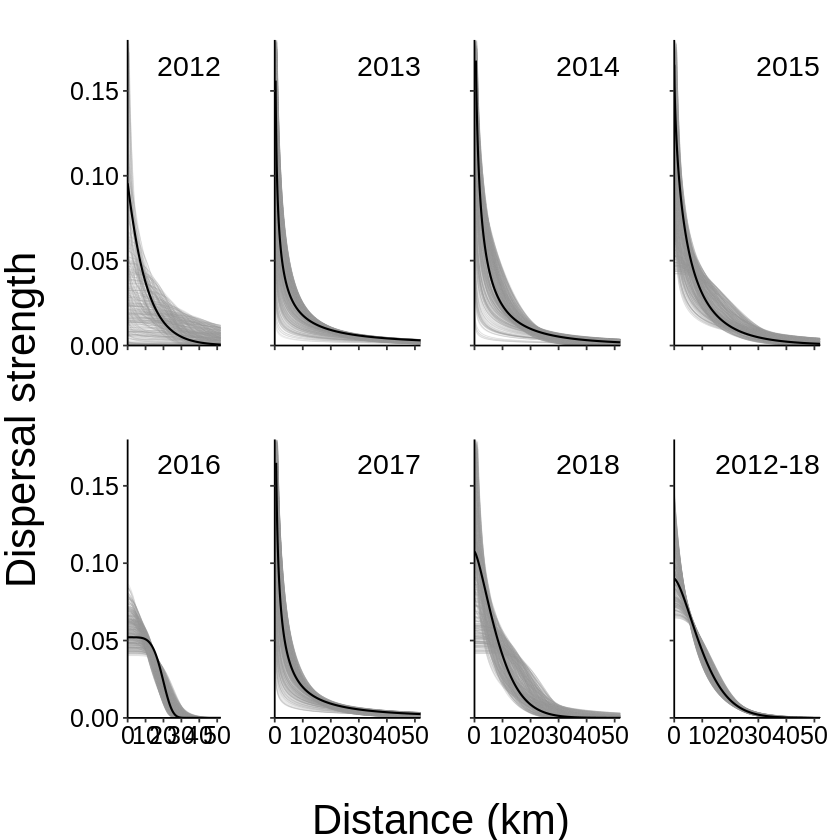

In [29]:
#add to plot
all <- plot_grid(disp_12_pub, disp_13_pub, disp_14_pub, disp_15_pub, disp_16_pub, disp_17_pub, disp_18_pub, disp_all_pub, ncol=4, scale=0.8) #, disp_15_pub,disp_16_pub, disp_17_pub, disp_18_pub, 
                 #disp_all_pub,  ncol=1) 
all_ann <- grid.arrange(arrangeGrob(all, bottom=grid::textGrob(label= "Distance (km)",
                    gp= gpar(fontsize=25, family="Helvetica", col="black", vjust=0)), 
                    left=grid::textGrob(label="Dispersal strength", rot=90, 
                    gp= gpar(fontsize=25, family="Helvetica", col="black", hjust=1))))
#png
ggplot2::ggsave(filename="disp_panel_pub_4x4.png", width=40, height=20, units="cm", plot=all_ann, path="~/parentage/kernel_fitting/1340_loci/final_results/kernel_plots")
